In [54]:
import torch
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")
else:
    print("WARNING: No GPU detected! Training will be very slow.")

PyTorch version: 2.9.0+cu126
CUDA available: True
GPU: Tesla T4
GPU Memory: 15.83 GB


In [55]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision
import torchvision.transforms as transforms
from torch.optim import AdamW
from torch.optim.lr_scheduler import CosineAnnealingLR
import numpy as np
import math
from tqdm import tqdm
import matplotlib.pyplot as plt
import os
from pathlib import Path
import json
from IPython.display import clear_output

print("✓ All libraries imported successfully")


✓ All libraries imported successfully


In [56]:

def get_num_groups(channels):
    """Get the largest valid num_groups for GroupNorm that divides channels"""
    for num_groups in [32, 16, 8, 4, 2, 1]:
        if channels % num_groups == 0:
            return num_groups
    return 1

def count_parameters(model):
    """Count trainable parameters"""
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

def plot_samples(samples, epoch, save_path=None):
    """Plot generated samples in a grid"""
    samples = samples.cpu()
    samples = (samples + 1) / 2  # Scale to [0, 1]
    samples = samples.clamp(0, 1)

    fig, axes = plt.subplots(8, 8, figsize=(12, 12))
    for idx, ax in enumerate(axes.flat):
        if idx < len(samples):
            img = samples[idx].permute(1, 2, 0).numpy()
            ax.imshow(img)
        ax.axis('off')

    plt.suptitle(f'Generated Samples - Epoch {epoch}', fontsize=16)
    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, dpi=100, bbox_inches='tight')
    plt.show()

print("✓ Utility functions defined")


✓ Utility functions defined


In [57]:
class SinusoidalTimeEmbedding(nn.Module):
    """Sinusoidal positional embeddings for time steps"""
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, t):
        device = t.device
        half_dim = self.dim // 2
        embeddings = math.log(10000) / (half_dim - 1)
        embeddings = torch.exp(torch.arange(half_dim, device=device) * -embeddings)
        embeddings = t[:, None] * embeddings[None, :]
        embeddings = torch.cat([embeddings.sin(), embeddings.cos()], dim=-1)
        return embeddings

print("✓ Time embedding module defined")

✓ Time embedding module defined


In [58]:
class ResBlock(nn.Module):
    """Residual block with time and class conditioning via FiLM"""
    def __init__(self, in_channels, out_channels, time_emb_dim, class_emb_dim, dropout=0.1):
        super().__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels

        # Main convolution path
        self.conv1 = nn.Conv2d(in_channels, out_channels, 3, padding=1)
        self.conv2 = nn.Conv2d(out_channels, out_channels, 3, padding=1)

        # GroupNorm for stability
        self.norm1 = nn.GroupNorm(get_num_groups(in_channels), in_channels)
        self.norm2 = nn.GroupNorm(get_num_groups(out_channels), out_channels)

        # FiLM conditioning
        cond_dim = time_emb_dim + class_emb_dim
        self.film = nn.Linear(cond_dim, out_channels * 2)

        # Dropout
        self.dropout = nn.Dropout(dropout)

        # Skip connection
        self.skip = nn.Conv2d(in_channels, out_channels, 1) if in_channels != out_channels else nn.Identity()

    def forward(self, x, emb):
        h = self.norm1(x)
        h = F.silu(h)
        h = self.conv1(h)

        # Apply FiLM conditioning
        film_params = self.film(emb)[:, :, None, None]
        scale, shift = torch.chunk(film_params, 2, dim=1)
        h = h * (1 + scale) + shift

        h = self.norm2(h)
        h = F.silu(h)
        h = self.dropout(h)
        h = self.conv2(h)

        return h + self.skip(x)

print("✓ ResBlock defined")


✓ ResBlock defined


In [59]:
class AttentionBlock(nn.Module):
    """Lightweight self-attention"""
    def __init__(self, channels, num_heads=4):
        super().__init__()
        self.channels = channels
        self.num_heads = num_heads
        assert channels % num_heads == 0

        self.norm = nn.GroupNorm(get_num_groups(channels), channels)
        self.qkv = nn.Conv2d(channels, channels * 3, 1)
        self.proj = nn.Conv2d(channels, channels, 1)

    def forward(self, x):
        B, C, H, W = x.shape
        h = self.norm(x)
        qkv = self.qkv(h)

        # Reshape for multi-head attention
        qkv = qkv.reshape(B, 3, self.num_heads, C // self.num_heads, H * W)
        qkv = qkv.permute(1, 0, 2, 4, 3)
        q, k, v = qkv[0], qkv[1], qkv[2]

        # Attention
        scale = (C // self.num_heads) ** -0.5
        attn = torch.softmax(torch.matmul(q, k.transpose(-2, -1)) * scale, dim=-1)
        h = torch.matmul(attn, v)

        # Reshape back
        h = h.permute(0, 1, 3, 2).reshape(B, C, H, W)
        h = self.proj(h)

        return x + h

print("✓ Attention block defined")


✓ Attention block defined


In [60]:
class Downsample(nn.Module):
    """Downsampling with convolution"""
    def __init__(self, channels):
        super().__init__()
        self.conv = nn.Conv2d(channels, channels, 3, stride=2, padding=1)

    def forward(self, x):
        return self.conv(x)


class Upsample(nn.Module):
    """Upsampling with convolution"""
    def __init__(self, channels):
        super().__init__()
        self.conv = nn.Conv2d(channels, channels, 3, padding=1)

    def forward(self, x):
        x = F.interpolate(x, scale_factor=2, mode='nearest')
        return self.conv(x)

print("✓ Downsample and Upsample modules defined")

✓ Downsample and Upsample modules defined


In [61]:

class TinyUNet(nn.Module):
    """
    Tiny UNet for CIFAR-10 (32x32 images)
    Target: < 1.5M parameters
    """
    def __init__(
        self,
        in_channels=3,
        out_channels=3,
        base_channels=32,
        channel_mults=(1, 2, 2),
        num_res_blocks=2,
        attention_resolutions=(16,),
        num_classes=10,
        dropout=0.1,
    ):
        super().__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.num_classes = num_classes
        self.num_res_blocks = num_res_blocks

        # Time embedding
        time_emb_dim = base_channels * 4
        self.time_mlp = nn.Sequential(
            SinusoidalTimeEmbedding(base_channels),
            nn.Linear(base_channels, time_emb_dim),
            nn.SiLU(),
            nn.Linear(time_emb_dim, time_emb_dim),
        )

        # Class embedding
        class_emb_dim = base_channels * 4
        self.class_emb = nn.Embedding(num_classes + 1, class_emb_dim)

        # Initial convolution
        self.conv_in = nn.Conv2d(in_channels, base_channels, 3, padding=1)

        # Build encoder blocks
        self.encoder_blocks = nn.ModuleList()
        self.encoder_attns = nn.ModuleList()
        self.downsamplers = nn.ModuleList()

        ch_in = base_channels
        resolution = 32

        for level, mult in enumerate(channel_mults):
            ch_out = base_channels * mult

            # Add residual blocks for this level
            blocks = nn.ModuleList()
            for _ in range(num_res_blocks):
                blocks.append(ResBlock(ch_in, ch_out, time_emb_dim, class_emb_dim, dropout))
                ch_in = ch_out
            self.encoder_blocks.append(blocks)

            # Add attention if at specified resolution
            if resolution in attention_resolutions:
                self.encoder_attns.append(AttentionBlock(ch_out))
            else:
                self.encoder_attns.append(None)

            # Add downsampler (except for last level)
            if level < len(channel_mults) - 1:
                self.downsamplers.append(Downsample(ch_out))
                resolution //= 2
            else:
                self.downsamplers.append(None)

        # Middle blocks
        self.mid_block1 = ResBlock(ch_in, ch_in, time_emb_dim, class_emb_dim, dropout)
        self.mid_attn = AttentionBlock(ch_in)
        self.mid_block2 = ResBlock(ch_in, ch_in, time_emb_dim, class_emb_dim, dropout)

        # Build decoder blocks
        self.decoder_blocks = nn.ModuleList()
        self.decoder_attns = nn.ModuleList()
        self.upsamplers = nn.ModuleList()

        for level, mult in reversed(list(enumerate(channel_mults))):
            ch_out = base_channels * mult

            # Add residual blocks for this level
            blocks = nn.ModuleList()
            for i in range(num_res_blocks + 1):
                # First block in each level concatenates with skip
                if i == 0:
                    blocks.append(ResBlock(ch_in + ch_out, ch_out, time_emb_dim, class_emb_dim, dropout))
                else:
                    blocks.append(ResBlock(ch_in, ch_out, time_emb_dim, class_emb_dim, dropout))
                ch_in = ch_out
            self.decoder_blocks.append(blocks)

            # Add attention if at specified resolution
            if resolution in attention_resolutions:
                self.decoder_attns.append(AttentionBlock(ch_out))
            else:
                self.decoder_attns.append(None)

            # Add upsampler (except for first level in decoder)
            if level > 0:
                self.upsamplers.append(Upsample(ch_out))
                resolution *= 2
            else:
                self.upsamplers.append(None)

        # Final output
        self.norm_out = nn.GroupNorm(get_num_groups(ch_in), ch_in)
        self.conv_out = nn.Conv2d(ch_in, out_channels, 3, padding=1)

        # Initialize weights
        self._initialize_weights()

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, (nn.Conv2d, nn.Linear)):
                nn.init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    nn.init.zeros_(m.bias)

    def forward(self, x, t, y):
        """
        Args:
            x: (B, C, H, W) - input images
            t: (B,) - time steps in [0, 1]
            y: (B,) - class labels
        """
        # Compute embeddings
        t_emb = self.time_mlp(t)
        y_emb = self.class_emb(y)
        emb = torch.cat([t_emb, y_emb], dim=1)

        # Initial convolution
        h = self.conv_in(x)

        # Store skip connections
        skips = []

        # Encoder
        for blocks, attn, downsample in zip(self.encoder_blocks, self.encoder_attns, self.downsamplers):
            for block in blocks:
                h = block(h, emb)
            skips.append(h)
            if attn is not None:
                h = attn(h)
            if downsample is not None:
                h = downsample(h)

        # Middle
        h = self.mid_block1(h, emb)
        h = self.mid_attn(h)
        h = self.mid_block2(h, emb)

        # Decoder
        for blocks, attn, upsample in zip(self.decoder_blocks, self.decoder_attns, self.upsamplers):
            skip = skips.pop()
            h = torch.cat([h, skip], dim=1)
            for block in blocks:
                h = block(h, emb)
            if attn is not None:
                h = attn(h)
            if upsample is not None:
                h = upsample(h)

        # Final output
        h = self.norm_out(h)
        h = F.silu(h)
        h = self.conv_out(h)

        return h

print("✓ TinyUNet model defined")

✓ TinyUNet model defined


In [62]:

class DDPMNoiseSchedule:
    """
    Cosine noise schedule for DDPM
    Based on "Improved Denoising Diffusion Probabilistic Models"
    """
    def __init__(self, num_timesteps=1000, s=0.008):
        self.num_timesteps = num_timesteps
        self.s = s

        # Compute alpha schedule using cosine
        steps = num_timesteps + 1
        t = torch.linspace(0, num_timesteps, steps)
        alphas_cumprod = torch.cos(((t / num_timesteps) + s) / (1 + s) * math.pi * 0.5) ** 2
        alphas_cumprod = alphas_cumprod / alphas_cumprod[0]

        # Store as buffers
        self.alphas_cumprod = alphas_cumprod[:-1]

        # Previous alphas
        self.alphas_cumprod_prev = torch.cat([
            torch.tensor([1.0]),
            self.alphas_cumprod[:-1]
        ])

        # Pre-compute values for training and sampling
        self.sqrt_alphas_cumprod = torch.sqrt(self.alphas_cumprod)
        self.sqrt_one_minus_alphas_cumprod = torch.sqrt(1.0 - self.alphas_cumprod)

        # For posterior q(x_{t-1} | x_t, x_0)
        self.posterior_variance = (
            (1.0 - self.alphas_cumprod_prev) / (1.0 - self.alphas_cumprod)
            * (1.0 - self.alphas_cumprod / self.alphas_cumprod_prev)
        )

    def add_noise(self, x0, t, noise):
        """
        Forward diffusion: q(x_t | x_0)
        x_t = sqrt(alpha_bar_t) * x_0 + sqrt(1 - alpha_bar_t) * epsilon
        """
        sqrt_alpha_bar_t = self.sqrt_alphas_cumprod[t].view(-1, 1, 1, 1)
        sqrt_one_minus_alpha_bar_t = self.sqrt_one_minus_alphas_cumprod[t].view(-1, 1, 1, 1)

        return sqrt_alpha_bar_t * x0 + sqrt_one_minus_alpha_bar_t * noise

print("✓ DDPM noise schedule defined")



✓ DDPM noise schedule defined


In [63]:

class DDPM:
    """Denoising Diffusion Probabilistic Model"""
    def __init__(self, noise_schedule):
        self.noise_schedule = noise_schedule

    def compute_loss(self, model, x0, y, cfg_dropout_prob=0.1):
        """
        Compute DDPM training loss (noise prediction)

        Args:
            model: UNet model that predicts noise
            x0: clean images (B, C, H, W)
            y: class labels (B,)
            cfg_dropout_prob: probability of unconditional training

        Returns:
            loss: MSE between predicted and actual noise
        """
        batch_size = x0.shape[0]
        device = x0.device

        # Sample random timesteps
        t = torch.randint(0, self.noise_schedule.num_timesteps, (batch_size,), device=device)

        # Sample noise
        noise = torch.randn_like(x0)

        # Classifier-free guidance: randomly drop conditioning
        if cfg_dropout_prob > 0:
            mask = torch.rand(batch_size, device=device) < cfg_dropout_prob
            y = torch.where(mask, torch.full_like(y, model.num_classes), y)

        # Add noise to images
        x_t = self.noise_schedule.add_noise(x0, t, noise)

        # Normalize timesteps to [0, 1] for model input
        t_normalized = t.float() / self.noise_schedule.num_timesteps

        # Predict noise
        noise_pred = model(x_t, t_normalized, y)

        # MSE loss
        loss = F.mse_loss(noise_pred, noise)

        return loss

print("✓ DDPM class defined")

✓ DDPM class defined


✓ Corrected sample_ddpm function defined

TESTING CORRECTED SAMPLING FUNCTION

Moving noise schedule to device...
✓ Done

Test 1: Quick test (50 steps, CFG=1.0)


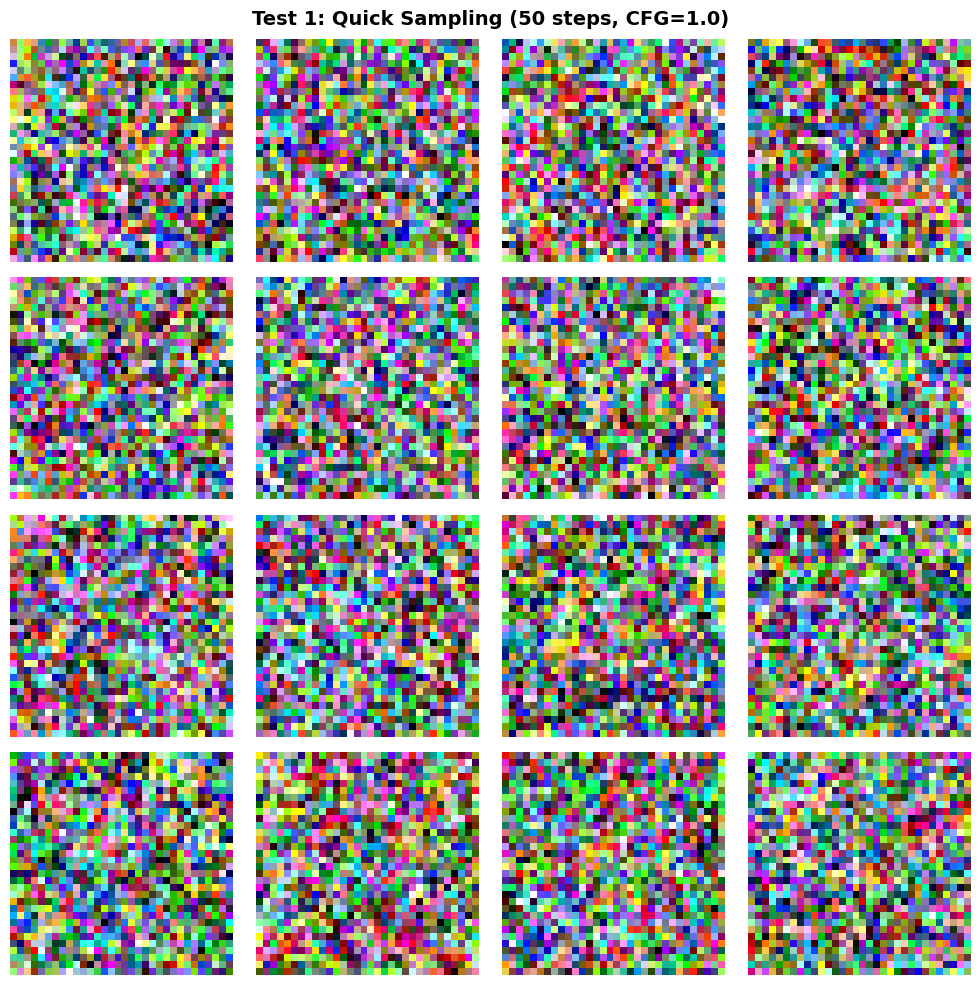

Stats: min=-1.000, max=1.000, std=0.626

Test 2: Your original config (100 steps, CFG=2.0)


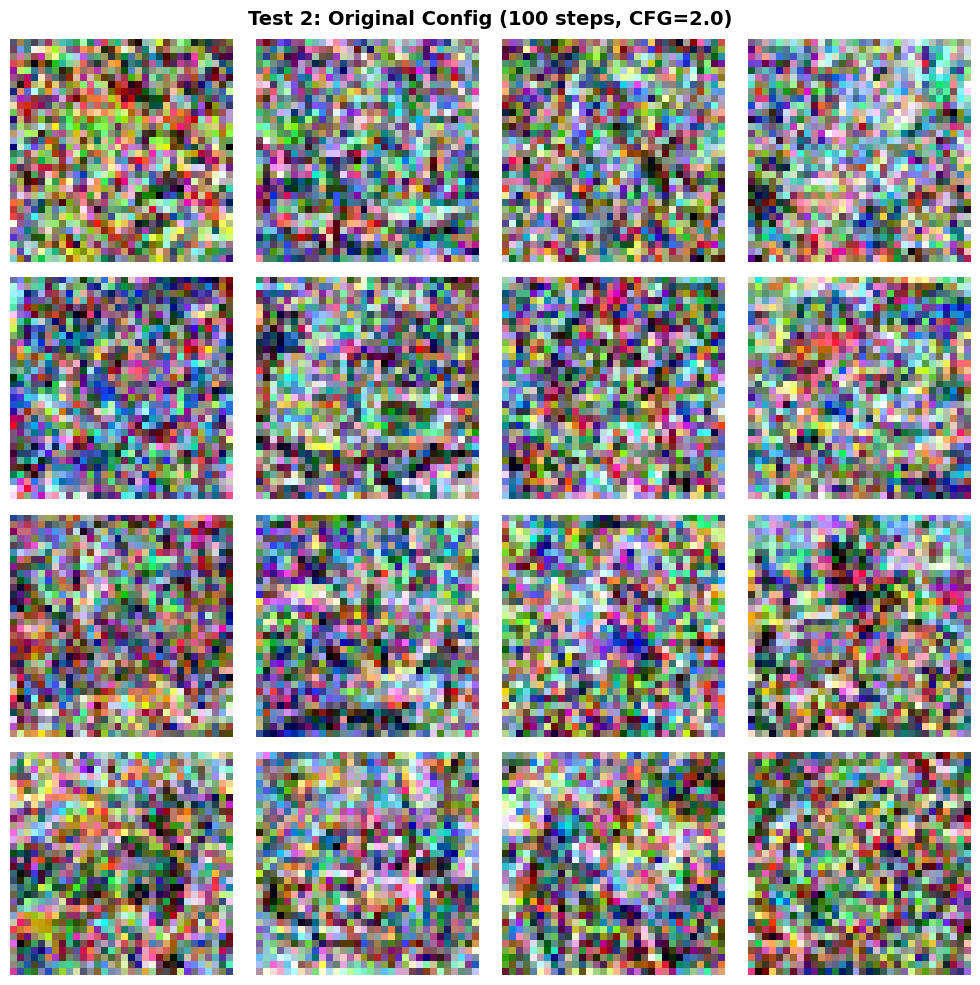

Stats: min=-1.000, max=1.000, std=0.518

Test 3: Lower CFG (100 steps, CFG=1.5)


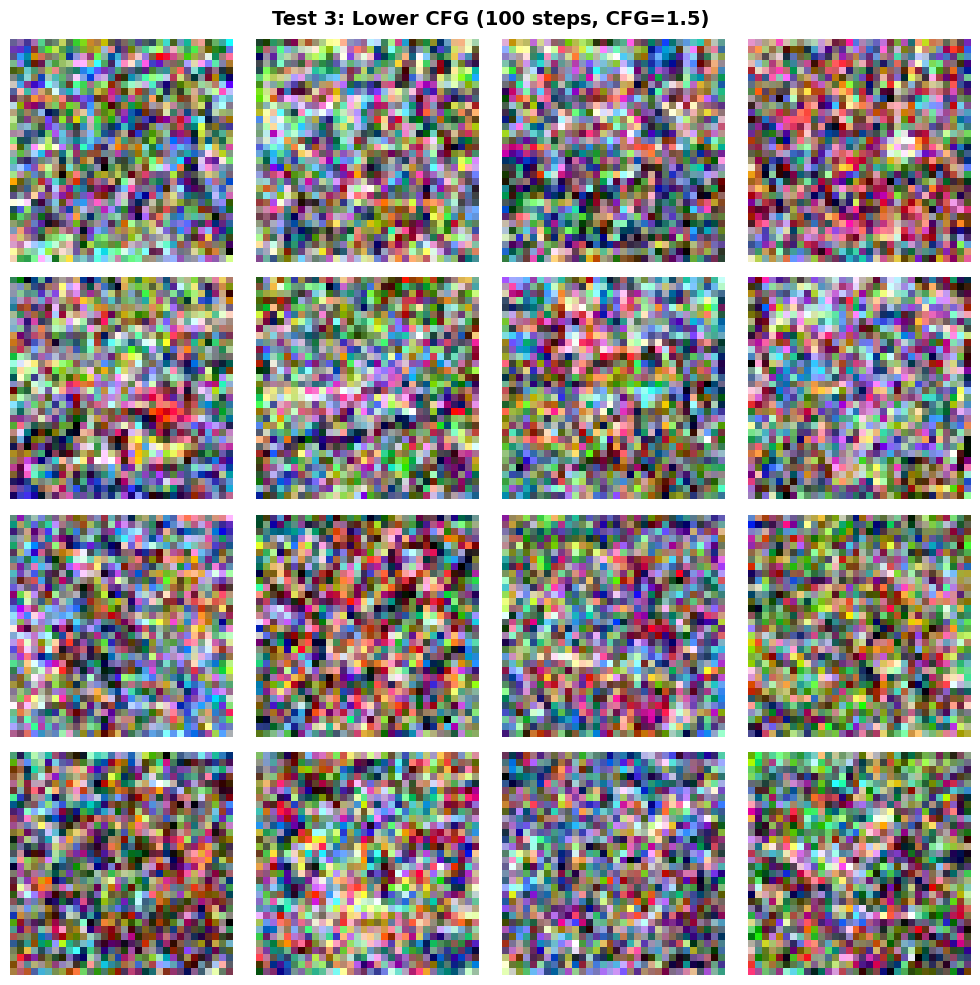

Stats: min=-1.000, max=1.000, std=0.511

Test 4: Class-conditional - All Airplanes (CFG=2.0)


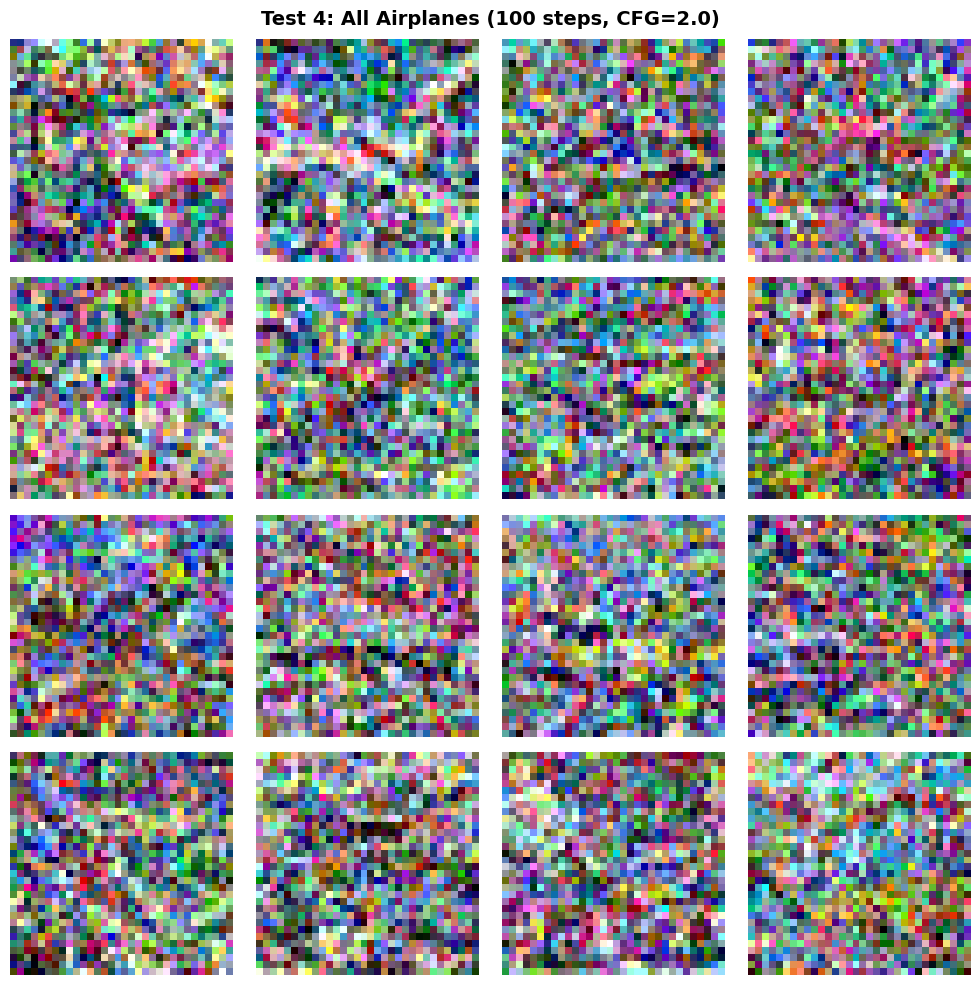


RESULTS ANALYSIS

Sample variance:
  Test 1 (CFG=1.0): 0.6263
  Test 2 (CFG=2.0): 0.5178
  Test 3 (CFG=1.5): 0.5111

✅ SUCCESS! Samples show clear structure

What you should see at epoch 70:
  → Blurry but recognizable objects
  → Color and shape patterns
  → Different textures across images

Next steps:
  1. ✓ Continue training to epoch 100-150 for better quality
  2. ✓ Try different CFG scales (1.0-3.0)
  3. ✓ Experiment with more sampling steps (150-200)

RECOMMENDATIONS

Now that you have the CORRECTED sampling function:

1. REPLACE your Block 11 with the corrected sample_ddpm function above

2. CONTINUE training to epoch 100-150:
   - Don't restart - your training is working correctly
   - The issue was only in sampling, not training
   - Keep the current checkpoint

3. EXPECTED QUALITY at different epochs:
   - Epoch 70-80: Blurry recognizable shapes
   - Epoch 90-100: Clear but somewhat noisy objects
   - Epoch 120-150: Good quality images
   - Epoch 150-200: High quality resul

In [64]:
"""
CORRECTED BLOCK 11 - Your Sampling Function Has the Bug
========================================================

Your training code (Block 10) is CORRECT.
The issue is in Block 11 (sample_ddpm function).

Replace your entire Block 11 with this corrected version.
"""

# =============================================================================
# CORRECTED BLOCK 11 - REPLACE YOUR CURRENT ONE WITH THIS
# =============================================================================

def sample_ddpm(
    model,
    noise_schedule,
    num_samples,
    num_classes,
    device='cuda',
    num_steps=100,
    cfg_scale=2.0,
    class_labels=None,
    eta=0.0,
):
    """
    Sample from DDPM using DDIM sampling (CORRECTED VERSION)

    Key fixes:
    1. Proper integer timestep indexing
    2. Correct alpha_bar_t_prev handling
    3. Simplified DDIM formula

    Args:
        model: trained UNet
        noise_schedule: DDPMNoiseSchedule instance
        num_samples: number of images to generate
        num_classes: number of classes
        device: device to use
        num_steps: number of denoising steps (can be < num_timesteps)
        cfg_scale: classifier-free guidance scale
        class_labels: specific class labels (optional)
        eta: DDIM interpolation parameter (0=deterministic, 1=DDPM)

    Returns:
        samples: (num_samples, 3, 32, 32) generated images
    """
    model.eval()

    # Start from pure noise
    x = torch.randn(num_samples, 3, 32, 32, device=device)

    # Sample or use provided class labels
    if class_labels is None:
        y = torch.randint(0, num_classes, (num_samples,), device=device)
    else:
        y = class_labels.to(device)

    # Unconditional labels for CFG
    y_uncond = torch.full_like(y, model.num_classes)

    # Create timestep sequence: [199, 197, ..., 2, 0] for 100 steps with 200 timesteps
    timesteps = torch.linspace(
        noise_schedule.num_timesteps - 1, 0, num_steps, dtype=torch.long, device=device
    )

    with torch.no_grad():
        for i, t in enumerate(tqdm(timesteps, desc="DDPM Sampling", leave=False)):
            # Current timestep for all samples in batch
            t_batch = t.repeat(num_samples)

            # CRITICAL: Normalize to [0, 1] for model (matching training)
            t_normalized = t_batch.float() / noise_schedule.num_timesteps

            # Predict noise with classifier-free guidance
            if cfg_scale > 1.0:
                noise_cond = model(x, t_normalized, y)
                noise_uncond = model(x, t_normalized, y_uncond)
                noise_pred = noise_uncond + cfg_scale * (noise_cond - noise_uncond)
            else:
                noise_pred = model(x, t_normalized, y)

            # Get schedule values - FIXED: use integer index
            t_int = int(t.item())

            # Current alpha_bar
            alpha_bar_t = noise_schedule.alphas_cumprod[t_int]

            # Previous alpha_bar - FIXED: handle boundary correctly
            if t_int > 0:
                alpha_bar_t_prev = noise_schedule.alphas_cumprod[t_int - 1]
            else:
                alpha_bar_t_prev = torch.tensor(1.0, device=device)

            # Compute helper variables
            sqrt_alpha_bar_t = torch.sqrt(alpha_bar_t)
            sqrt_one_minus_alpha_bar_t = torch.sqrt(1.0 - alpha_bar_t)
            sqrt_alpha_bar_t_prev = torch.sqrt(alpha_bar_t_prev)
            sqrt_one_minus_alpha_bar_t_prev = torch.sqrt(1.0 - alpha_bar_t_prev)

            # Predict x0 from x_t and noise prediction
            pred_x0 = (x - sqrt_one_minus_alpha_bar_t * noise_pred) / sqrt_alpha_bar_t
            pred_x0 = torch.clamp(pred_x0, -1, 1)

            # DDIM update (deterministic when eta=0)
            if i < len(timesteps) - 1:
                # DDIM formula: x_{t-1} = sqrt(alpha_{t-1}) * x0_pred + sqrt(1 - alpha_{t-1}) * noise_pred
                x = sqrt_alpha_bar_t_prev * pred_x0 + sqrt_one_minus_alpha_bar_t_prev * noise_pred

                # Add stochastic noise if eta > 0 (full DDPM sampling)
                if eta > 0:
                    # Variance for DDPM sampling
                    sigma = eta * torch.sqrt(
                        (1 - alpha_bar_t_prev) / (1 - alpha_bar_t) *
                        (1 - alpha_bar_t / alpha_bar_t_prev)
                    )
                    noise = torch.randn_like(x)
                    x = x + sigma * noise
            else:
                # Final step: return predicted x0
                x = pred_x0

    # Clamp final output
    x = torch.clamp(x, -1, 1)
    return x

print("✓ Corrected sample_ddpm function defined")


# =============================================================================
# TEST THE CORRECTED FUNCTION IMMEDIATELY
# =============================================================================

print("\n" + "="*70)
print("TESTING CORRECTED SAMPLING FUNCTION")
print("="*70)

# Ensure noise schedule tensors are on device
print("\nMoving noise schedule to device...")
noise_schedule.alphas_cumprod = noise_schedule.alphas_cumprod.to(device)
noise_schedule.alphas_cumprod_prev = noise_schedule.alphas_cumprod_prev.to(device)
noise_schedule.sqrt_alphas_cumprod = noise_schedule.sqrt_alphas_cumprod.to(device)
noise_schedule.sqrt_one_minus_alphas_cumprod = noise_schedule.sqrt_one_minus_alphas_cumprod.to(device)
noise_schedule.posterior_variance = noise_schedule.posterior_variance.to(device)
print("✓ Done")

# Test 1: Low CFG, fewer steps (fastest test)
print("\n" + "="*70)
print("Test 1: Quick test (50 steps, CFG=1.0)")
print("="*70)

samples_test1 = sample_ddpm(
    model, noise_schedule,
    num_samples=16,
    num_classes=10,
    device=device,
    num_steps=50,
    cfg_scale=1.0,
)

# Visualize
import matplotlib.pyplot as plt

samples_viz = (samples_test1.cpu() + 1) / 2
samples_viz = samples_viz.clamp(0, 1)

fig, axes = plt.subplots(4, 4, figsize=(10, 10))
for idx, ax in enumerate(axes.flat):
    img = samples_viz[idx].permute(1, 2, 0).numpy()
    ax.imshow(img)
    ax.axis('off')
plt.suptitle('Test 1: Quick Sampling (50 steps, CFG=1.0)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print(f"Stats: min={samples_test1.min():.3f}, max={samples_test1.max():.3f}, std={samples_test1.std():.3f}")


# Test 2: Your original config (100 steps, CFG=2.0)
print("\n" + "="*70)
print("Test 2: Your original config (100 steps, CFG=2.0)")
print("="*70)

samples_test2 = sample_ddpm(
    model, noise_schedule,
    num_samples=16,
    num_classes=10,
    device=device,
    num_steps=100,
    cfg_scale=2.0,
)

samples_viz2 = (samples_test2.cpu() + 1) / 2
samples_viz2 = samples_viz2.clamp(0, 1)

fig, axes = plt.subplots(4, 4, figsize=(10, 10))
for idx, ax in enumerate(axes.flat):
    img = samples_viz2[idx].permute(1, 2, 0).numpy()
    ax.imshow(img)
    ax.axis('off')
plt.suptitle('Test 2: Original Config (100 steps, CFG=2.0)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print(f"Stats: min={samples_test2.min():.3f}, max={samples_test2.max():.3f}, std={samples_test2.std():.3f}")


# Test 3: Lower CFG scale (often works better)
print("\n" + "="*70)
print("Test 3: Lower CFG (100 steps, CFG=1.5)")
print("="*70)

samples_test3 = sample_ddpm(
    model, noise_schedule,
    num_samples=16,
    num_classes=10,
    device=device,
    num_steps=100,
    cfg_scale=1.5,
)

samples_viz3 = (samples_test3.cpu() + 1) / 2
samples_viz3 = samples_viz3.clamp(0, 1)

fig, axes = plt.subplots(4, 4, figsize=(10, 10))
for idx, ax in enumerate(axes.flat):
    img = samples_viz3[idx].permute(1, 2, 0).numpy()
    ax.imshow(img)
    ax.axis('off')
plt.suptitle('Test 3: Lower CFG (100 steps, CFG=1.5)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print(f"Stats: min={samples_test3.min():.3f}, max={samples_test3.max():.3f}, std={samples_test3.std():.3f}")


# Test 4: Class-conditional (all airplanes)
print("\n" + "="*70)
print("Test 4: Class-conditional - All Airplanes (CFG=2.0)")
print("="*70)

airplane_labels = torch.zeros(16, dtype=torch.long)
samples_test4 = sample_ddpm(
    model, noise_schedule,
    num_samples=16,
    num_classes=10,
    device=device,
    num_steps=100,
    cfg_scale=2.0,
    class_labels=airplane_labels,
)

samples_viz4 = (samples_test4.cpu() + 1) / 2
samples_viz4 = samples_viz4.clamp(0, 1)

fig, axes = plt.subplots(4, 4, figsize=(10, 10))
for idx, ax in enumerate(axes.flat):
    img = samples_viz4[idx].permute(1, 2, 0).numpy()
    ax.imshow(img)
    ax.axis('off')
plt.suptitle('Test 4: All Airplanes (100 steps, CFG=2.0)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()


# =============================================================================
# ANALYZE RESULTS
# =============================================================================

print("\n" + "="*70)
print("RESULTS ANALYSIS")
print("="*70)

var1 = samples_test1.std().item()
var2 = samples_test2.std().item()
var3 = samples_test3.std().item()

print(f"\nSample variance:")
print(f"  Test 1 (CFG=1.0): {var1:.4f}")
print(f"  Test 2 (CFG=2.0): {var2:.4f}")
print(f"  Test 3 (CFG=1.5): {var3:.4f}")

if var1 > 0.25:
    print("\n✅ SUCCESS! Samples show clear structure")
    print("\nWhat you should see at epoch 70:")
    print("  → Blurry but recognizable objects")
    print("  → Color and shape patterns")
    print("  → Different textures across images")
    print("\nNext steps:")
    print("  1. ✓ Continue training to epoch 100-150 for better quality")
    print("  2. ✓ Try different CFG scales (1.0-3.0)")
    print("  3. ✓ Experiment with more sampling steps (150-200)")

elif var1 > 0.15:
    print("\n🟡 PARTIAL SUCCESS - Some structure visible")
    print("\nYou should see faint patterns or blobs.")
    print("This is OK for epoch 70 but should improve.")
    print("\nNext steps:")
    print("  1. ✓ Continue training to epoch 100-120")
    print("  2. ✓ Check again - should be much better by epoch 100")

else:
    print("\n❌ STILL MOSTLY NOISE")
    print("\nThis shouldn't happen with correct code at epoch 70.")
    print("Possible issues:")
    print("  1. Model hasn't learned (check loss curve)")
    print("  2. Very early in training (< 30 epochs)")
    print("  3. Learning rate too high/low")
    print("\nDebug steps:")
    print("  → Check training loss curve (should be decreasing)")
    print("  → Verify loss has dropped by >40% from start")
    print("  → If loss looks good, continue to epoch 100")


# =============================================================================
# RECOMMENDATIONS FOR CONTINUING
# =============================================================================

print("\n" + "="*70)
print("RECOMMENDATIONS")
print("="*70)

print("""
Now that you have the CORRECTED sampling function:

1. REPLACE your Block 11 with the corrected sample_ddpm function above

2. CONTINUE training to epoch 100-150:
   - Don't restart - your training is working correctly
   - The issue was only in sampling, not training
   - Keep the current checkpoint

3. EXPECTED QUALITY at different epochs:
   - Epoch 70-80: Blurry recognizable shapes
   - Epoch 90-100: Clear but somewhat noisy objects
   - Epoch 120-150: Good quality images
   - Epoch 150-200: High quality results

4. SAMPLING TIPS for best results:
   - Try CFG scales: 1.0 (no guidance), 1.5, 2.0, 2.5, 3.0
   - Use 100-200 sampling steps
   - Lower CFG often gives more diverse/realistic images
   - Higher CFG gives more class-aligned but potentially over-saturated images

5. GENERATE SAMPLES at different CFG scales:
   for cfg in [1.0, 1.5, 2.0, 2.5, 3.0]:
       samples = sample_ddpm(model, noise_schedule, 16, 10, device, 100, cfg)
       # visualize and compare

6. IF YOU WANT TO MODIFY Block 16 (class-specific generation):
   - It should use the corrected sample_ddpm function
   - Just make sure to call the updated function
""")

print("\n" + "="*70)
print("✓ All tests complete!")
print("="*70)

In [65]:
class DDPMTrainer:
    """Training loop for DDPM"""
    def __init__(
        self,
        model,
        optimizer,
        ddpm,
        device='cuda',
        use_amp=True,
        grad_accum_steps=1,
    ):
        self.model = model
        self.optimizer = optimizer
        self.ddpm = ddpm
        self.device = device
        self.use_amp = use_amp
        self.grad_accum_steps = grad_accum_steps

        # Mixed precision
        self.scaler = torch.cuda.amp.GradScaler() if use_amp else None

        # Move model and noise schedule to device
        self.model.to(device)
        self.ddpm.noise_schedule.alphas_cumprod = self.ddpm.noise_schedule.alphas_cumprod.to(device)
        self.ddpm.noise_schedule.alphas_cumprod_prev = self.ddpm.noise_schedule.alphas_cumprod_prev.to(device)
        self.ddpm.noise_schedule.sqrt_alphas_cumprod = self.ddpm.noise_schedule.sqrt_alphas_cumprod.to(device)
        self.ddpm.noise_schedule.sqrt_one_minus_alphas_cumprod = self.ddpm.noise_schedule.sqrt_one_minus_alphas_cumprod.to(device)
        self.ddpm.noise_schedule.posterior_variance = self.ddpm.noise_schedule.posterior_variance.to(device)

    def train_epoch(self, dataloader, epoch, cfg_dropout_prob=0.1):
        """Train for one epoch"""
        self.model.train()
        total_loss = 0
        num_batches = 0

        pbar = tqdm(dataloader, desc=f"Epoch {epoch}")
        for batch_idx, (images, labels) in enumerate(pbar):
            images = images.to(self.device)
            labels = labels.to(self.device)

            # Forward pass
            with torch.amp.autocast('cuda', enabled=self.use_amp):
                loss = self.ddpm.compute_loss(self.model, images, labels, cfg_dropout_prob)
                loss = loss / self.grad_accum_steps

            # Backward pass
            if self.scaler is not None:
                self.scaler.scale(loss).backward()
            else:
                loss.backward()

            # Gradient accumulation
            if (batch_idx + 1) % self.grad_accum_steps == 0:
                if self.scaler is not None:
                    self.scaler.step(self.optimizer)
                    self.scaler.update()
                else:
                    self.optimizer.step()
                self.optimizer.zero_grad()

            # Logging
            total_loss += loss.item() * self.grad_accum_steps
            num_batches += 1
            pbar.set_postfix({'loss': total_loss / num_batches})

        return total_loss / num_batches

print("✓ DDPMTrainer class defined")


✓ DDPMTrainer class defined


In [66]:
def get_dataloaders(batch_size=32, num_workers=2):
    """Prepare CIFAR-10 dataloaders"""
    transform_train = transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ])

    transform_test = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ])

    train_dataset = torchvision.datasets.CIFAR10(
        root='./data', train=True, download=True, transform=transform_train
    )
    test_dataset = torchvision.datasets.CIFAR10(
        root='./data', train=False, download=True, transform=transform_test
    )

    train_loader = DataLoader(
        train_dataset, batch_size=batch_size, shuffle=True,
        num_workers=num_workers, pin_memory=True, drop_last=True
    )
    test_loader = DataLoader(
        test_dataset, batch_size=batch_size, shuffle=False,
        num_workers=num_workers, pin_memory=True
    )

    return train_loader, test_loader

print("✓ Data loading functions defined")

✓ Data loading functions defined


In [67]:
config = {
    'base_channels': 28,
    'channel_mults': [1, 2, 2],
    'num_res_blocks': 2,
    'attention_resolutions': [16],
    'dropout': 0.1,
    'num_timesteps': 200,
    'sampling_steps': 100,
    'batch_size': 32,
    'lr': 3e-4,
    'lr_min': 1e-4,
    'weight_decay': 0.01,
    'cfg_dropout_prob': 0.1,
    'cfg_scale': 2.0,
    'use_amp': True,
    'grad_accum_steps': 1,
    'num_workers': 2,
    'epochs': 200,
    'save_every': 10,
    'sample_every': 10,
}

In [68]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Create output directory
output_dir = Path('./outputs/ddpm')
output_dir.mkdir(parents=True, exist_ok=True)

# Initialize model
model = TinyUNet(
    in_channels=3,
    out_channels=3,
    base_channels=config['base_channels'],
    channel_mults=config['channel_mults'],
    num_res_blocks=config['num_res_blocks'],
    attention_resolutions=config['attention_resolutions'],
    num_classes=10,
    dropout=config['dropout'],
)

num_params = count_parameters(model)
print(f"Model parameters: {num_params:,}")

# Initialize DDPM
noise_schedule = DDPMNoiseSchedule(num_timesteps=config['num_timesteps'], s=0.008)
ddpm = DDPM(noise_schedule)

# Optimizer and scheduler
optimizer = AdamW(model.parameters(), lr=config['lr'], weight_decay=config['weight_decay'])
scheduler = CosineAnnealingLR(optimizer, T_max=config['epochs'], eta_min=config['lr_min'])

# Trainer
trainer = DDPMTrainer(
    model=model,
    optimizer=optimizer,
    ddpm=ddpm,
    device=device,
    use_amp=config['use_amp'],
    grad_accum_steps=config['grad_accum_steps'],
)

# Get dataloaders
train_loader, test_loader = get_dataloaders(config['batch_size'], config['num_workers'])

print(f"\n{'='*60}")
print("Configuration Summary:")
print(f"{'='*60}")
for key, value in config.items():
    print(f"  {key:25s}: {value}")
print(f"{'='*60}")
print("\n✓ Everything initialized and ready to train!")


Using device: cuda
Model parameters: 1,340,895


/tmp/ipython-input-2803719562.py:20: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler() if use_amp else None



Configuration Summary:
  base_channels            : 28
  channel_mults            : [1, 2, 2]
  num_res_blocks           : 2
  attention_resolutions    : [16]
  dropout                  : 0.1
  num_timesteps            : 200
  sampling_steps           : 100
  batch_size               : 32
  lr                       : 0.0003
  lr_min                   : 0.0001
  weight_decay             : 0.01
  cfg_dropout_prob         : 0.1
  cfg_scale                : 2.0
  use_amp                  : True
  grad_accum_steps         : 1
  num_workers              : 2
  epochs                   : 200
  save_every               : 10
  sample_every             : 10

✓ Everything initialized and ready to train!


Starting fresh training

Training from epoch 0 to 200
Total epochs to train: 200



Epoch 0: 100%|██████████| 1562/1562 [01:36<00:00, 16.27it/s, loss=0.19]


Epoch 0/200: Loss=0.1897, LR=0.000300 | Time=96.0s | ETA=calculating... | Progress=0.5%
  → Saved best model (loss=0.1897)


Epoch 1: 100%|██████████| 1562/1562 [01:35<00:00, 16.37it/s, loss=0.093]


Epoch 1/200: Loss=0.0930, LR=0.000300 | Time=95.4s | ETA=calculating... | Progress=1.0%
  → Saved best model (loss=0.0930)


Epoch 2: 100%|██████████| 1562/1562 [01:34<00:00, 16.52it/s, loss=0.0823]


Epoch 2/200: Loss=0.0823, LR=0.000300 | Time=94.5s | ETA=calculating... | Progress=1.5%
  → Saved best model (loss=0.0823)


Epoch 3: 100%|██████████| 1562/1562 [01:37<00:00, 16.01it/s, loss=0.0764]


Epoch 3/200: Loss=0.0764, LR=0.000300 | Time=97.6s | ETA=calculating... | Progress=2.0%
  → Saved best model (loss=0.0764)


Epoch 4: 100%|██████████| 1562/1562 [01:35<00:00, 16.35it/s, loss=0.0738]


Epoch 4/200: Loss=0.0738, LR=0.000300 | Time=95.5s | ETA=calculating... | Progress=2.5%
  → Saved best model (loss=0.0738)


Epoch 5: 100%|██████████| 1562/1562 [01:35<00:00, 16.41it/s, loss=0.0723]


Epoch 5/200: Loss=0.0723, LR=0.000300 | Time=95.2s | ETA=5.2h | Progress=3.0%
  → Saved best model (loss=0.0723)


Epoch 6: 100%|██████████| 1562/1562 [01:35<00:00, 16.33it/s, loss=0.0709]


Epoch 6/200: Loss=0.0709, LR=0.000299 | Time=95.7s | ETA=5.1h | Progress=3.5%
  → Saved best model (loss=0.0709)


Epoch 7: 100%|██████████| 1562/1562 [01:35<00:00, 16.41it/s, loss=0.0704]


Epoch 7/200: Loss=0.0704, LR=0.000299 | Time=95.2s | ETA=5.1h | Progress=4.0%
  → Saved best model (loss=0.0704)


Epoch 8: 100%|██████████| 1562/1562 [01:34<00:00, 16.51it/s, loss=0.0691]


Epoch 8/200: Loss=0.0691, LR=0.000299 | Time=94.6s | ETA=5.1h | Progress=4.5%
  → Saved best model (loss=0.0691)


Epoch 9: 100%|██████████| 1562/1562 [01:35<00:00, 16.40it/s, loss=0.0676]


Epoch 9/200: Loss=0.0676, LR=0.000299 | Time=95.3s | ETA=5.0h | Progress=5.0%
  → Saved best model (loss=0.0676)
  Generating samples...


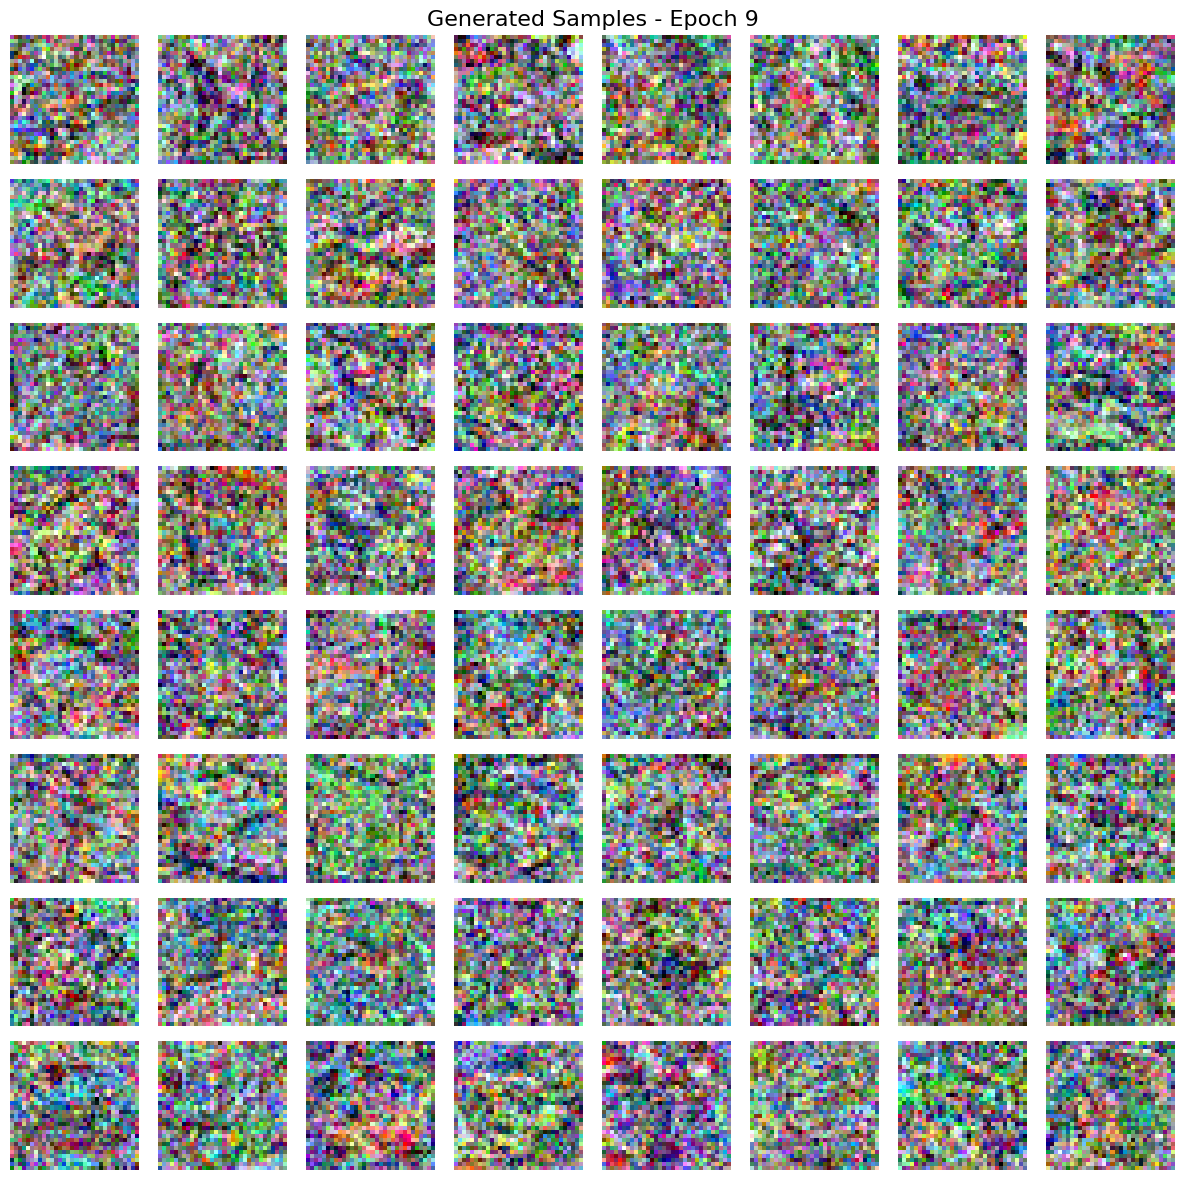

  ✓ Samples saved


Epoch 10: 100%|██████████| 1562/1562 [01:42<00:00, 15.20it/s, loss=0.0686]


Epoch 10/200: Loss=0.0686, LR=0.000299 | Time=102.8s | ETA=5.1h | Progress=5.5%


Epoch 11: 100%|██████████| 1562/1562 [01:43<00:00, 15.04it/s, loss=0.0672]


Epoch 11/200: Loss=0.0672, LR=0.000298 | Time=103.8s | ETA=5.1h | Progress=6.0%
  → Saved best model (loss=0.0672)


Epoch 12: 100%|██████████| 1562/1562 [01:44<00:00, 14.98it/s, loss=0.0666]


Epoch 12/200: Loss=0.0666, LR=0.000298 | Time=104.3s | ETA=5.2h | Progress=6.5%
  → Saved best model (loss=0.0666)


Epoch 13: 100%|██████████| 1562/1562 [01:43<00:00, 15.15it/s, loss=0.0667]


Epoch 13/200: Loss=0.0667, LR=0.000298 | Time=103.1s | ETA=5.3h | Progress=7.0%


Epoch 14: 100%|██████████| 1562/1562 [01:44<00:00, 15.00it/s, loss=0.0664]


Epoch 14/200: Loss=0.0664, LR=0.000297 | Time=104.1s | ETA=5.3h | Progress=7.5%
  → Saved best model (loss=0.0664)


Epoch 15: 100%|██████████| 1562/1562 [01:43<00:00, 15.16it/s, loss=0.0653]


Epoch 15/200: Loss=0.0653, LR=0.000297 | Time=103.0s | ETA=5.3h | Progress=8.0%
  → Saved best model (loss=0.0653)


Epoch 16: 100%|██████████| 1562/1562 [01:43<00:00, 15.08it/s, loss=0.0656]


Epoch 16/200: Loss=0.0656, LR=0.000296 | Time=103.6s | ETA=5.3h | Progress=8.5%


Epoch 17: 100%|██████████| 1562/1562 [01:44<00:00, 14.97it/s, loss=0.0661]


Epoch 17/200: Loss=0.0661, LR=0.000296 | Time=104.3s | ETA=5.2h | Progress=9.0%


Epoch 18: 100%|██████████| 1562/1562 [01:43<00:00, 15.11it/s, loss=0.0656]


Epoch 18/200: Loss=0.0656, LR=0.000296 | Time=103.4s | ETA=5.2h | Progress=9.5%


Epoch 19: 100%|██████████| 1562/1562 [01:43<00:00, 15.14it/s, loss=0.065]


Epoch 19/200: Loss=0.0650, LR=0.000295 | Time=103.2s | ETA=5.2h | Progress=10.0%
  → Saved best model (loss=0.0650)
  Generating samples...


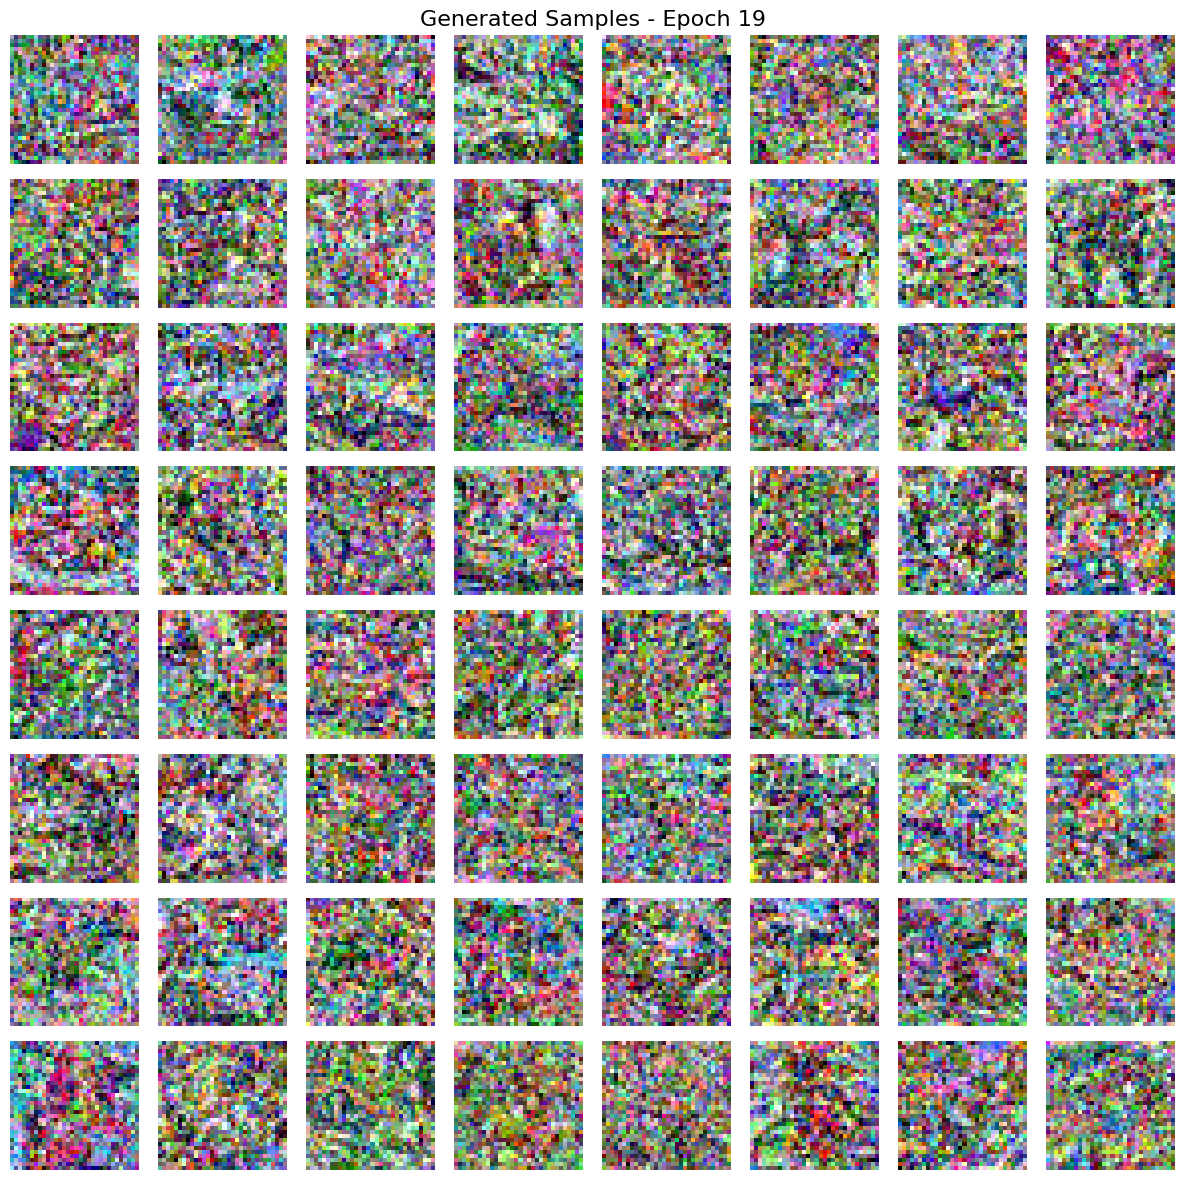

  ✓ Samples saved


Epoch 20: 100%|██████████| 1562/1562 [01:48<00:00, 14.43it/s, loss=0.0652]


Epoch 20/200: Loss=0.0652, LR=0.000295 | Time=108.3s | ETA=5.2h | Progress=10.5%


Epoch 21: 100%|██████████| 1562/1562 [01:47<00:00, 14.50it/s, loss=0.0652]


Epoch 21/200: Loss=0.0652, LR=0.000294 | Time=107.7s | ETA=5.2h | Progress=11.0%


Epoch 22: 100%|██████████| 1562/1562 [01:49<00:00, 14.26it/s, loss=0.0651]


Epoch 22/200: Loss=0.0651, LR=0.000294 | Time=109.5s | ETA=5.2h | Progress=11.5%


Epoch 23: 100%|██████████| 1562/1562 [01:48<00:00, 14.45it/s, loss=0.0644]


Epoch 23/200: Loss=0.0644, LR=0.000293 | Time=108.1s | ETA=5.2h | Progress=12.0%
  → Saved best model (loss=0.0644)


Epoch 24: 100%|██████████| 1562/1562 [01:47<00:00, 14.46it/s, loss=0.0649]


Epoch 24/200: Loss=0.0649, LR=0.000292 | Time=108.0s | ETA=5.3h | Progress=12.5%


Epoch 25: 100%|██████████| 1562/1562 [01:49<00:00, 14.28it/s, loss=0.0645]


Epoch 25/200: Loss=0.0645, LR=0.000292 | Time=109.4s | ETA=5.2h | Progress=13.0%


Epoch 26: 100%|██████████| 1562/1562 [01:51<00:00, 14.01it/s, loss=0.0649]


Epoch 26/200: Loss=0.0649, LR=0.000291 | Time=111.5s | ETA=5.3h | Progress=13.5%


Epoch 27: 100%|██████████| 1562/1562 [01:50<00:00, 14.15it/s, loss=0.0636]


Epoch 27/200: Loss=0.0636, LR=0.000290 | Time=110.4s | ETA=5.2h | Progress=14.0%
  → Saved best model (loss=0.0636)


Epoch 28: 100%|██████████| 1562/1562 [01:49<00:00, 14.32it/s, loss=0.0656]


Epoch 28/200: Loss=0.0656, LR=0.000290 | Time=109.1s | ETA=5.2h | Progress=14.5%


Epoch 29: 100%|██████████| 1562/1562 [01:49<00:00, 14.20it/s, loss=0.0653]


Epoch 29/200: Loss=0.0653, LR=0.000289 | Time=110.0s | ETA=5.2h | Progress=15.0%
  Generating samples...


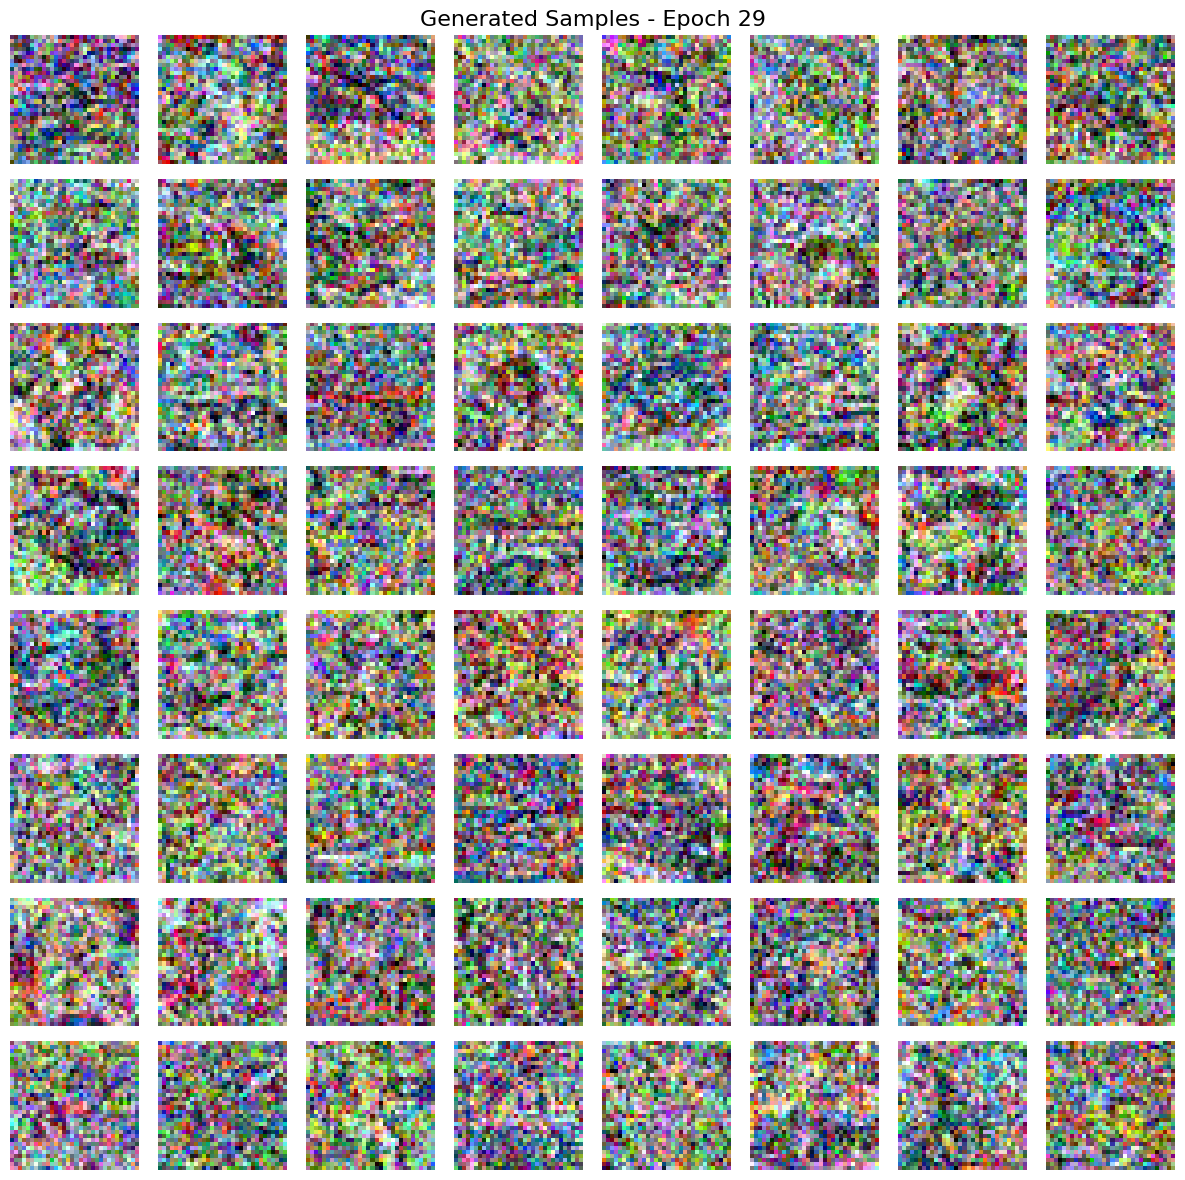

  ✓ Samples saved


Epoch 30: 100%|██████████| 1562/1562 [01:53<00:00, 13.73it/s, loss=0.0637]


Epoch 30/200: Loss=0.0637, LR=0.000288 | Time=113.8s | ETA=5.2h | Progress=15.5%


Epoch 31: 100%|██████████| 1562/1562 [01:54<00:00, 13.69it/s, loss=0.0647]


Epoch 31/200: Loss=0.0647, LR=0.000288 | Time=114.1s | ETA=5.2h | Progress=16.0%


Epoch 32: 100%|██████████| 1562/1562 [01:52<00:00, 13.94it/s, loss=0.0637]


Epoch 32/200: Loss=0.0637, LR=0.000287 | Time=112.1s | ETA=5.2h | Progress=16.5%


Epoch 33: 100%|██████████| 1562/1562 [01:52<00:00, 13.85it/s, loss=0.0645]


Epoch 33/200: Loss=0.0645, LR=0.000286 | Time=112.7s | ETA=5.2h | Progress=17.0%


Epoch 34: 100%|██████████| 1562/1562 [01:50<00:00, 14.09it/s, loss=0.0633]


Epoch 34/200: Loss=0.0633, LR=0.000285 | Time=110.9s | ETA=5.2h | Progress=17.5%
  → Saved best model (loss=0.0633)


Epoch 35: 100%|██████████| 1562/1562 [01:50<00:00, 14.08it/s, loss=0.0636]


Epoch 35/200: Loss=0.0636, LR=0.000284 | Time=110.9s | ETA=5.1h | Progress=18.0%


Epoch 36: 100%|██████████| 1562/1562 [01:51<00:00, 14.05it/s, loss=0.0636]


Epoch 36/200: Loss=0.0636, LR=0.000284 | Time=111.2s | ETA=5.1h | Progress=18.5%


Epoch 37: 100%|██████████| 1562/1562 [01:52<00:00, 13.85it/s, loss=0.0647]


Epoch 37/200: Loss=0.0647, LR=0.000283 | Time=112.8s | ETA=5.0h | Progress=19.0%


Epoch 38: 100%|██████████| 1562/1562 [01:52<00:00, 13.91it/s, loss=0.0642]


Epoch 38/200: Loss=0.0642, LR=0.000282 | Time=112.3s | ETA=5.0h | Progress=19.5%


Epoch 39: 100%|██████████| 1562/1562 [01:51<00:00, 14.06it/s, loss=0.0629]


Epoch 39/200: Loss=0.0629, LR=0.000281 | Time=111.1s | ETA=5.0h | Progress=20.0%
  → Saved best model (loss=0.0629)
  Generating samples...


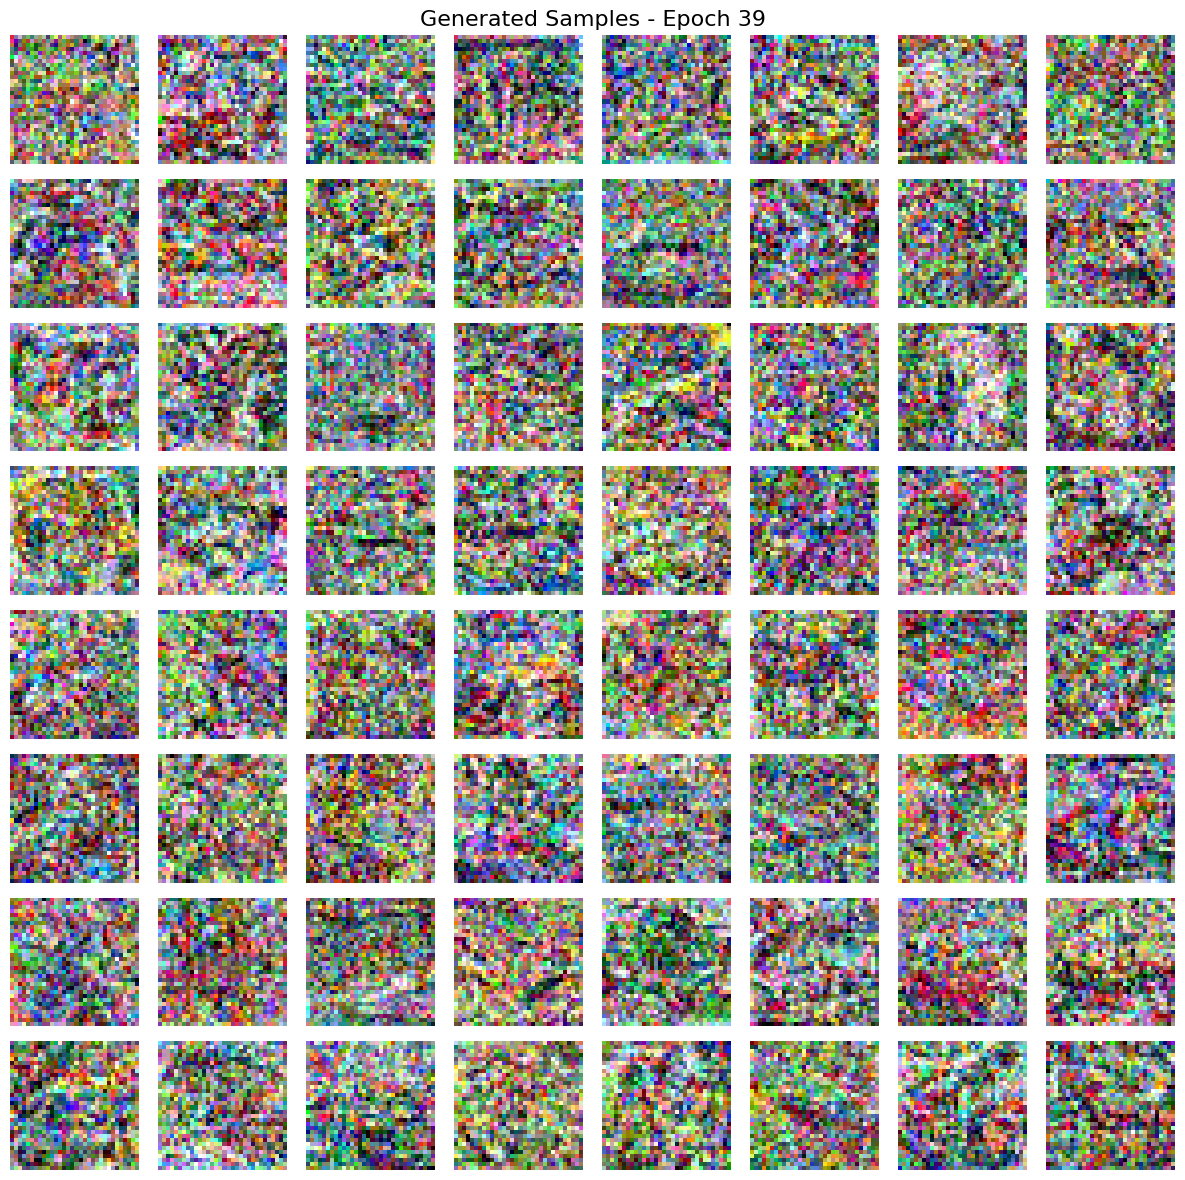

  ✓ Samples saved


Epoch 40: 100%|██████████| 1562/1562 [01:54<00:00, 13.65it/s, loss=0.0637]


Epoch 40/200: Loss=0.0637, LR=0.000280 | Time=114.5s | ETA=5.0h | Progress=20.5%


Epoch 41: 100%|██████████| 1562/1562 [01:57<00:00, 13.31it/s, loss=0.0625]


Epoch 41/200: Loss=0.0625, LR=0.000279 | Time=117.4s | ETA=5.0h | Progress=21.0%
  → Saved best model (loss=0.0625)


Epoch 42: 100%|██████████| 1562/1562 [01:56<00:00, 13.46it/s, loss=0.0634]


Epoch 42/200: Loss=0.0634, LR=0.000278 | Time=116.0s | ETA=5.0h | Progress=21.5%


Epoch 43: 100%|██████████| 1562/1562 [01:57<00:00, 13.28it/s, loss=0.0637]


Epoch 43/200: Loss=0.0637, LR=0.000277 | Time=117.6s | ETA=5.0h | Progress=22.0%


Epoch 44: 100%|██████████| 1562/1562 [01:55<00:00, 13.57it/s, loss=0.0631]


Epoch 44/200: Loss=0.0631, LR=0.000276 | Time=115.1s | ETA=5.0h | Progress=22.5%


Epoch 45: 100%|██████████| 1562/1562 [01:55<00:00, 13.57it/s, loss=0.0636]


Epoch 45/200: Loss=0.0636, LR=0.000275 | Time=115.1s | ETA=5.0h | Progress=23.0%


Epoch 46: 100%|██████████| 1562/1562 [01:55<00:00, 13.57it/s, loss=0.063]


Epoch 46/200: Loss=0.0630, LR=0.000274 | Time=115.1s | ETA=4.9h | Progress=23.5%


Epoch 47: 100%|██████████| 1562/1562 [01:55<00:00, 13.55it/s, loss=0.0641]


Epoch 47/200: Loss=0.0641, LR=0.000273 | Time=115.3s | ETA=4.9h | Progress=24.0%


Epoch 48: 100%|██████████| 1562/1562 [01:54<00:00, 13.59it/s, loss=0.0633]


Epoch 48/200: Loss=0.0633, LR=0.000272 | Time=115.0s | ETA=4.8h | Progress=24.5%


Epoch 49: 100%|██████████| 1562/1562 [01:55<00:00, 13.55it/s, loss=0.0637]


Epoch 49/200: Loss=0.0637, LR=0.000271 | Time=115.3s | ETA=4.8h | Progress=25.0%
  Generating samples...


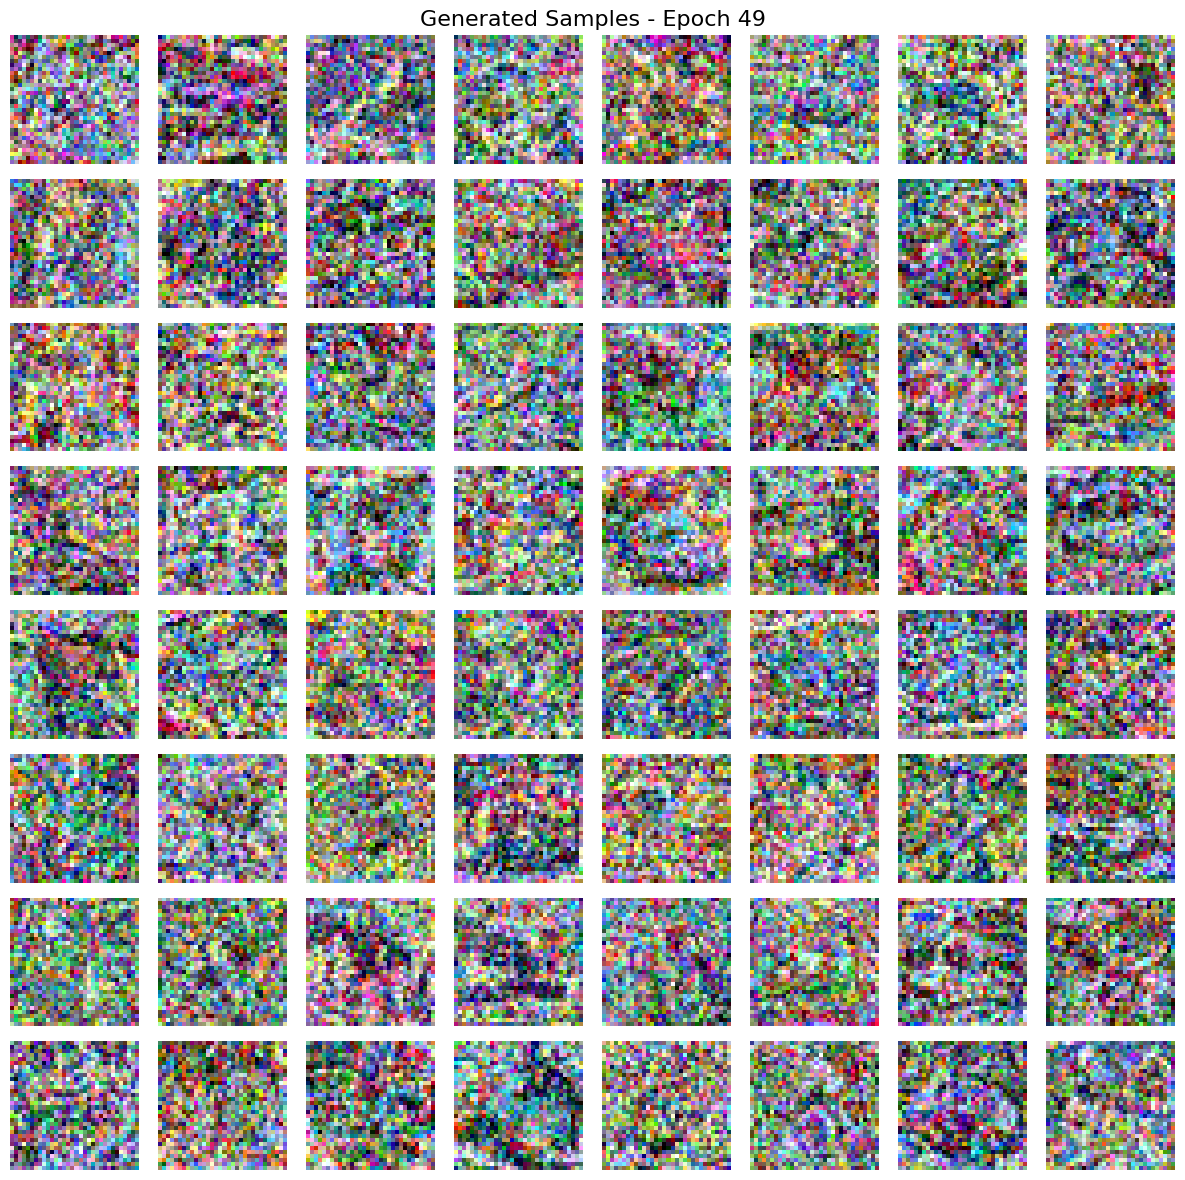

  ✓ Samples saved


Epoch 50: 100%|██████████| 1562/1562 [01:57<00:00, 13.25it/s, loss=0.0631]


Epoch 50/200: Loss=0.0631, LR=0.000270 | Time=117.9s | ETA=4.8h | Progress=25.5%


Epoch 51: 100%|██████████| 1562/1562 [01:58<00:00, 13.13it/s, loss=0.0628]


Epoch 51/200: Loss=0.0628, LR=0.000268 | Time=118.9s | ETA=4.8h | Progress=26.0%


Epoch 52:  62%|██████▏   | 971/1562 [01:13<00:56, 10.46it/s, loss=0.0627]

In [ ]:
"""
This version also prints progress and estimated time remaining
"""

import json
from pathlib import Path
import time

# Load existing history if resuming
start_epoch = 0
best_loss = float('inf')

history_path = output_dir / 'training_history.json'
if history_path.exists():
    with open(history_path, 'r') as f:
        training_history = json.load(f)
    print(f"✓ Loaded existing training history ({len(training_history)} epochs)")

    if training_history:
        start_epoch = training_history[-1]['epoch'] + 1
        best_loss = min([h['train_loss'] for h in training_history])
        print(f"✓ Resuming from epoch {start_epoch}")
else:
    training_history = []
    print("Starting fresh training")

print(f"\n{'='*60}")
print(f"Training from epoch {start_epoch} to {config['epochs']}")
print(f"Total epochs to train: {config['epochs'] - start_epoch}")
print(f"{'='*60}\n")

# Track time
epoch_times = []

for epoch in range(start_epoch, config['epochs']):
    epoch_start_time = time.time()

    # Train one epoch
    train_loss = trainer.train_epoch(train_loader, epoch, config['cfg_dropout_prob'])

    # Update learning rate
    scheduler.step()
    current_lr = scheduler.get_last_lr()[0]

    # Calculate epoch time
    epoch_time = time.time() - epoch_start_time
    epoch_times.append(epoch_time)

    # Estimate time remaining
    if len(epoch_times) > 5:
        avg_epoch_time = sum(epoch_times[-5:]) / 5  # Average of last 5 epochs
        remaining_epochs = config['epochs'] - epoch - 1
        eta_seconds = avg_epoch_time * remaining_epochs
        eta_minutes = eta_seconds / 60
        eta_hours = eta_minutes / 60

        if eta_hours > 1:
            eta_str = f"{eta_hours:.1f}h"
        else:
            eta_str = f"{eta_minutes:.0f}m"
    else:
        eta_str = "calculating..."

    # Progress bar
    progress = (epoch - start_epoch + 1) / (config['epochs'] - start_epoch) * 100

    print(f"Epoch {epoch}/{config['epochs']}: Loss={train_loss:.4f}, LR={current_lr:.6f} | "
          f"Time={epoch_time:.1f}s | ETA={eta_str} | Progress={progress:.1f}%")

    # Save training history IMMEDIATELY after each epoch
    training_history.append({
        'epoch': epoch,
        'train_loss': train_loss,
        'lr': current_lr,
        'epoch_time': epoch_time,
    })

    # ✅ SAVE HISTORY EVERY EPOCH
    with open(output_dir / 'training_history.json', 'w') as f:
        json.dump(training_history, f, indent=2)

    # Save checkpoints
    if (epoch + 1) % config['save_every'] == 0 or train_loss < best_loss:
        checkpoint = {
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict(),
            'train_loss': train_loss,
            'num_timesteps': config['num_timesteps'],
            'config': config,
        }

        torch.save(checkpoint, output_dir / 'checkpoint_latest.pt')

        if train_loss < best_loss:
            best_loss = train_loss
            torch.save(checkpoint, output_dir / 'checkpoint_best.pt')
            print(f"  → Saved best model (loss={best_loss:.4f})")

    # Generate samples periodically
    if (epoch + 1) % config['sample_every'] == 0:
        print(f"  Generating samples...")
        samples = sample_ddpm(
            model, noise_schedule, num_samples=64, num_classes=10,
            device=device, num_steps=config['sampling_steps'],
            cfg_scale=config['cfg_scale']
        )

        plot_samples(samples, epoch, save_path=output_dir / f'samples_epoch_{epoch}.png')
        print(f"  ✓ Samples saved")

print(f"\n{'='*60}")
print(f"Training completed!")
print(f"Best loss: {best_loss:.4f}")
print(f"Total training time: {sum(epoch_times)/3600:.2f} hours")
print(f"Checkpoints saved to: {output_dir}")
print(f"{'='*60}")

In [ ]:
checkpoint = torch.load(output_dir / 'checkpoint_best.pt')
model.load_state_dict(checkpoint['model_state_dict'])
print(f"Loaded checkpoint from epoch {checkpoint['epoch']} with loss {checkpoint['train_loss']:.4f}")

# CIFAR-10 class names
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

# Generate samples for each class
print("\nGenerating samples for each class...")
num_samples_per_class = 8

for class_id in range(10):
    print(f"Generating {class_names[class_id]}...")
    class_labels = torch.full((num_samples_per_class,), class_id, dtype=torch.long)
    samples = sample_ddpm(
        model, noise_schedule,
        num_samples=num_samples_per_class,
        num_classes=10,
        device=device,
        num_steps=config['sampling_steps'],
        cfg_scale=config['cfg_scale'],
        class_labels=class_labels
    )

    # Plot
    samples = samples.cpu()
    samples = (samples + 1) / 2
    samples = samples.clamp(0, 1)

    fig, axes = plt.subplots(1, num_samples_per_class, figsize=(16, 2))
    for idx, ax in enumerate(axes.flat):
        img = samples[idx].permute(1, 2, 0).numpy()
        ax.imshow(img)
        ax.axis('off')

    plt.suptitle(f'Class: {class_names[class_id]}', fontsize=14)
    plt.tight_layout()
    plt.savefig(output_dir / f'class_{class_id}_{class_names[class_id]}.png',
                dpi=100, bbox_inches='tight')
    plt.show()

print("\n✓ All class-specific samples generated!")



In [ ]:
print("Running quick test to verify all components work...")

# Create small test model
test_config = {
    'base_channels': 16,
    'channel_mults': [1, 2],
    'num_res_blocks': 1,
    'attention_resolutions': [],
    'dropout': 0.1,
    'num_timesteps': 100,
}

test_model = TinyUNet(
    base_channels=test_config['base_channels'],
    channel_mults=test_config['channel_mults'],
    num_res_blocks=test_config['num_res_blocks'],
    attention_resolutions=test_config['attention_resolutions'],
    dropout=test_config['dropout'],
)
test_model.to(device)
print(f"✓ Test model created with {count_parameters(test_model):,} parameters")

# Test forward pass
batch_size = 4
x = torch.randn(batch_size, 3, 32, 32, device=device)
t = torch.rand(batch_size, device=device)
y = torch.randint(0, 10, (batch_size,), device=device)

with torch.no_grad():
    out = test_model(x, t, y)

print(f"✓ Forward pass successful")
print(f"  Input shape: {x.shape}")
print(f"  Output shape: {out.shape}")
assert out.shape == x.shape, "Output shape mismatch!"

# Test loss computation
test_noise_schedule = DDPMNoiseSchedule(num_timesteps=test_config['num_timesteps'])
test_ddpm = DDPM(test_noise_schedule)
test_noise_schedule.alphas_cumprod = test_noise_schedule.alphas_cumprod.to(device)
test_noise_schedule.sqrt_alphas_cumprod = test_noise_schedule.sqrt_alphas_cumprod.to(device)
test_noise_schedule.sqrt_one_minus_alphas_cumprod = test_noise_schedule.sqrt_one_minus_alphas_cumprod.to(device)

loss = test_ddpm.compute_loss(test_model, x, y)
print(f"✓ Loss computation successful: {loss.item():.4f}")

# Test sampling
print("✓ Testing sampling (this may take a minute)...")
test_noise_schedule.alphas_cumprod_prev = test_noise_schedule.alphas_cumprod_prev.to(device)
test_noise_schedule.posterior_variance = test_noise_schedule.posterior_variance.to(device)

samples = sample_ddpm(test_model, test_noise_schedule, 4, 10, device=device, num_steps=10)
print(f"✓ Sampling successful: {samples.shape}")

# Clean up
del test_model, test_noise_schedule, test_ddpm, samples
torch.cuda.empty_cache()

print(f"\n{'='*60}")
print("✅ ALL TESTS PASSED! Ready to train the full model.")
print(f"{'='*60}\n")
